# DATA COLLECTION

# Necessary Imports

In [48]:
# Loading all dependencies:
import pandas as pd
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module('dependencies_for_data_generation')
N.load_module('dependencies_for_hmc_bnn')
N.load_module('dependencies_for_vi_bnn')
from dependencies_for_data_generation import *
from dependencies_for_hmc_bnn import *
from dependencies_for_vi_bnn import *

importing Jupyter notebook from .\dependencies_for_data_generation.ipynb
importing Jupyter notebook from .\dependencies_for_hmc_bnn.ipynb
importing Jupyter notebook from .\dependencies_for_vi_bnn.ipynb


# Training and Testing Data
The below function allows you to assign the global data variables to the data generated by the chosen synthetic regression problem.

In [49]:
cur_problem_id = None

def save_data_as_csv(problem_id, extra_tag=''):
    pd.DataFrame(data={'x_train':x_train.flatten(), 'y_train':y_train.flatten()}).to_csv(f'storage/synthetic_training_data--problem_{problem_id}{extra_tag}.csv', header=True)
    pd.DataFrame(data={'x_test':x_test.flatten(), 'y_test':y_test.flatten()}).to_csv(f'storage/synthetic_test_data--problem_{problem_id}{extra_tag}.csv', header=True)

def assign_data(problem_id, save_data=True, extra_tag=''):
    global x_train, y_train, x_test, y_test, cur_problem_id
    x_train, y_train, x_test, y_test = generate_data(problem_id, visualise_problem=False)
    if save_data:
        save_data_as_csv(problem_id, extra_tag)
    cur_problem_id = problem_id

# Other Global Variables

In [50]:
# Variable to keep track of the number of filtered samples for HMC (so that VI can use this value for its plots):
num_samples = None

# Data Collection Functions

## For HMC BNN

In [51]:
# REDEFINING UNNORMALISED LOG-PROBABILITY OF THE POSTERIOR
# NOTE: The unnormalised log-probability of the posterior is redefined to account for the newly trained functional model

def unnormalized_log_prob(θ):
    prior = make_prior(dims=θ.shape[0], σ=hyperparams['σ'])
    likelihood = make_likelihood(θ, functional_model, x_train, hyperparams['τ'])
    p = prior.log_prob(θ) + tf.reduce_sum(likelihood.log_prob(y_train))
    return p

#================================================
# HELPER FUNCTION FOR `run_hmc`
# NOTE: It is defined as a separate function to focus only on plotting if we have already trained the ANN and collected the samples

def plot_results_for_hmc_bnn(x_for_plotting, samples, random_samples_to_show, show_suptitle):
    # Specifying global variables:
    global functional_model
    
    y_predictions_for_plotting_1 = get_hmc_bnn_predictions(x_for_plotting, samples, functional_model, sample_draw_type='random', samples_to_show=random_samples_to_show)
    y_predictions_for_plotting_2 = get_hmc_bnn_predictions(x_for_plotting, samples, functional_model, sample_draw_type='iterative', samples_to_show='all')
    common_args = [samples, functional_model, x_train, y_train, x_test, y_test, x_for_plotting]
    plot_hmc_results(*common_args, y_predictions_for_plotting_1, samples_to_show=random_samples_to_show, show_suptitle=show_suptitle, version=1)
    plot_hmc_results(*common_args, y_predictions_for_plotting_2, samples_to_show=num_samples, show_suptitle=show_suptitle, version=2)

#================================================
# MAIN FUNCTION TO RUN HMC

def run_hmc(layer, σ, τ, train_params, hmc_params, hmc_filter_params, random_samples_to_show, lr=0.01, show_ann_train_results=False, show_hmc_results=True, show_suptitle=False, force_model_initialization=False, random_normal_initializer=False):
    # Specifying global variables:
    global hyperparams, functional_model, num_samples
    
    hyperparams['layer'] = layer
    hyperparams['σ'] = σ
    hyperparams['τ'] = τ

    #------------------------------------
    # Initialising and fitting the model if required:
    try:
        if force_model_initialization: raise Exception('force_model_initialization == True')
        functional_model.model.load_weights(f'storage/functional_model--problem_{cur_problem_id}.weights.h5')
        functional.model_weights = functional.model.get_weights()
    except:
        tmp = FunctionalModel(lr=lr, random_normal_initializer=random_normal_initializer)
        tmp.enhanced_fit(x_train, y_train, **train_params, problem_id=cur_problem_id)
        # Assigning the temporary model to the globally accessible model:
        functional_model = tmp
    
    #------------------------------------
    # Plotting the results:
    if show_ann_train_results:
        plot_ann_train_results(functional_model, x_train, y_train, x_test, y_test, show_suptitle)

    #------------------------------------
    # Obtaining HMC samples:
    hmc = HMC(unnormalized_log_prob, functional_model, **hmc_params)
    samples, is_accepted = hmc.run_chain()
    samples = hmc.get_filtered_samples(samples, is_accepted, **hmc_filter_params)
    num_samples = len(samples)

    #------------------------------------
    # Plotting HMC samples (if required and possible):
    if show_hmc_results and len(samples) > 0:
        x_for_plotting = get_x_for_plotting(x_train, y_train, x_test, y_test)
        plot_results_for_hmc_bnn(x_for_plotting, samples, random_samples_to_show, show_suptitle)

    return samples, is_accepted

## For VI BNN

In [52]:
# Helper function for `run_vi`:
# NOTE: It is defined as a separate function to focus only on plotting if we have already trained the BNN

def plot_results_for_vi_bnn(x_for_plotting, random_samples_to_show, show_suptitle):
    # Specifying global variables:
    global vi_bnn, num_samples
    
    y_predictions_for_plotting_1 = get_vi_bnn_predictions(x_for_plotting, vi_bnn, samples_to_show=random_samples_to_show)
    y_predictions_for_plotting_2 = get_vi_bnn_predictions(x_for_plotting, vi_bnn, samples_to_show=num_samples)
    common_args = [vi_bnn, x_train, y_train, x_test, y_test, x_for_plotting]
    plot_vi_results(*common_args, y_predictions_for_plotting_1, samples_to_show=random_samples_to_show, show_suptitle=show_suptitle, version=1)
    if num_samples is None:
        plot_vi_results(*common_args, y_predictions_for_plotting_2, samples_to_show=random_samples_to_show, show_suptitle=show_suptitle, version=2)
    else:
        plot_vi_results(*common_args, y_predictions_for_plotting_2, samples_to_show=num_samples, show_suptitle=show_suptitle, version=2)

#================================================
# MAIN FUNCTION TO RUN VI

def run_vi(prior_mu, prior_sigma, bayesian_layers, train_params, random_samples_to_show, lr=0.01, force_model_initialization=False, show_vi_results=True, show_suptitle=False):
    # Specifying global variables:
    global vi_bnn

    #------------------------------------
    # Initialising and fitting the model if required:
    try:
        if force_model_initialization: raise Exception('force_model_initialization == True')
        vi_bnn.model.load_state_dict(torch.load(f'storage/vi_bnn--problem_{cur_problem_id}--weights.pth')['model_state_dict'])
    except:
        tmp = BNN(prior_mu=prior_mu, prior_sigma=prior_sigma, bayesian_layers=bayesian_layers, lr=lr)
        tmp.enhanced_fit(x_train, y_train, **train_params, problem_id=cur_problem_id)
        # Assigning the trained model to the appropriate global variable:
        vi_bnn = tmp

    #------------------------------------
    # Plotting the results:
    if show_vi_results:
        x_for_plotting = get_x_for_plotting(x_train, y_train, x_test, y_test)
        plot_results_for_vi_bnn(x_for_plotting, random_samples_to_show, show_suptitle)

# Control Parameters

**Common parameters**:

In [53]:
train_params_for_hmc_bnn = {'epochs':500, 'batch_size':32, 'num_reinitializations':5}
train_params_for_vi_bnn = {'epochs':3000, 'batch_size':100, 'num_reinitializations':5}
random_samples_to_show = 10
lr = 0.01

**For HMC BNN**:

In [54]:
hmc_params = {'num_burnin_steps':5000, 'num_results':10000, 'num_leapfrog_steps':100, 'step_size':1.0}
hmc_filter_params = {'keep_burnin':False, 'keep_only_accepted':True}
layer = 2 # The layer of weights to distribute
print(f'NOTE: There are {len(functional_model.model_weights)} layers of weights in the functional model.')

NOTE: There are 6 layers of weights in the functional model.


**For VI BNN**:

In [55]:
prior_mu, prior_sigma = 0, 1
bayesian_layers = 'hidden'

# Data Collection

## Problem A

In [10]:
assign_data('A')

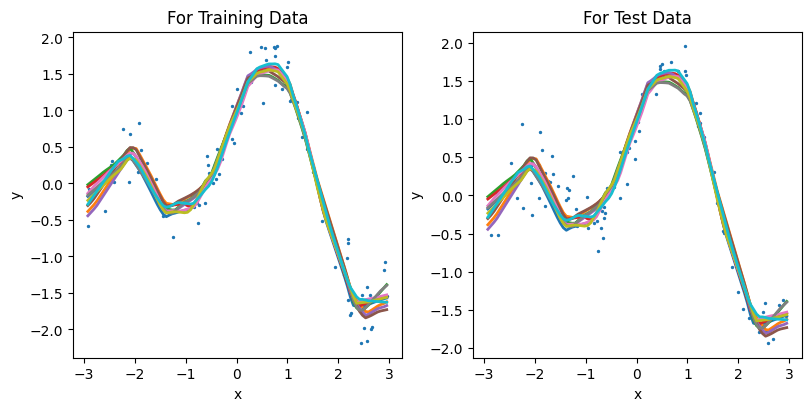

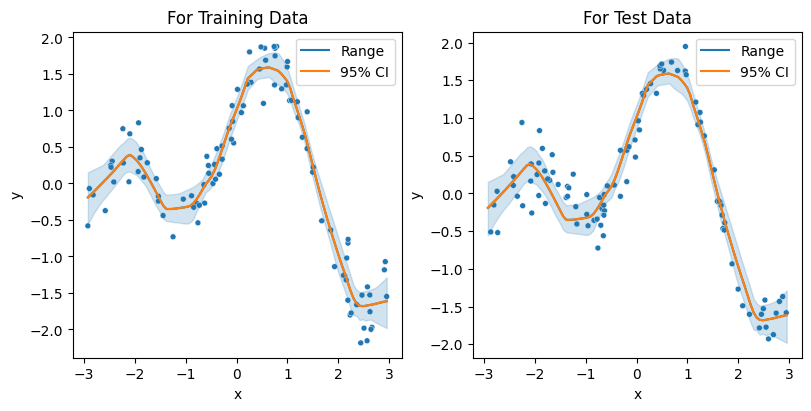

In [20]:
σ, τ = 1, 0.25
samples, is_accepted = run_hmc(layer, σ, τ, train_params_for_hmc_bnn, hmc_params, hmc_filter_params, random_samples_to_show, lr=lr, force_model_initialization=True)
np.save(f'storage/hmc_samples--problem_{cur_problem_id}', np.array(samples), allow_pickle=False)

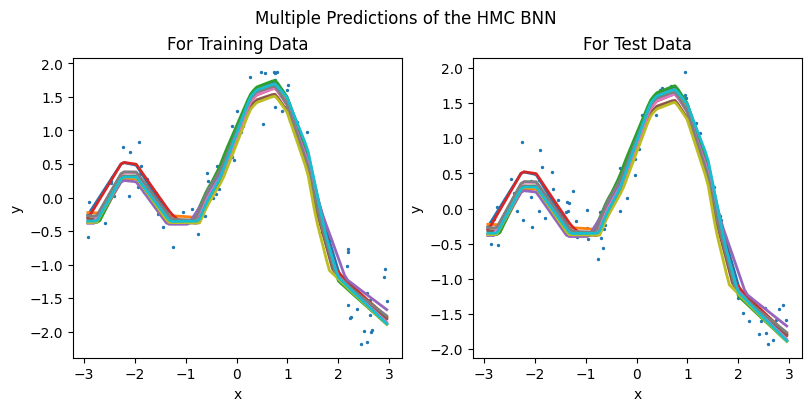

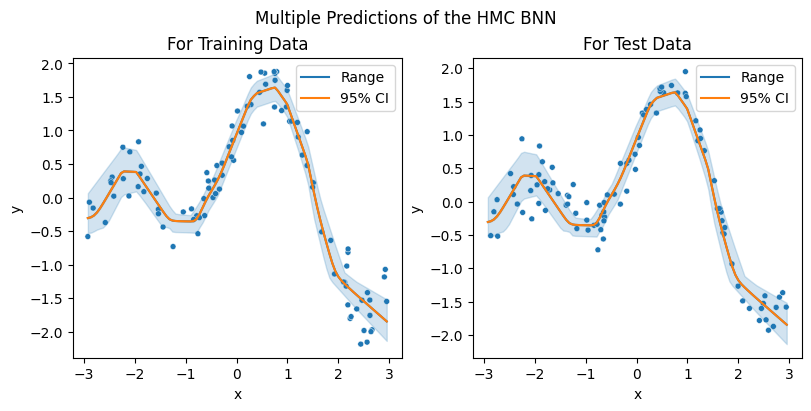

In [21]:
run_vi(prior_mu, prior_sigma, bayesian_layers, train_params_for_vi_bnn, random_samples_to_show, lr=lr, force_model_initialization=True)

## Problem B

In [56]:
assign_data('B')

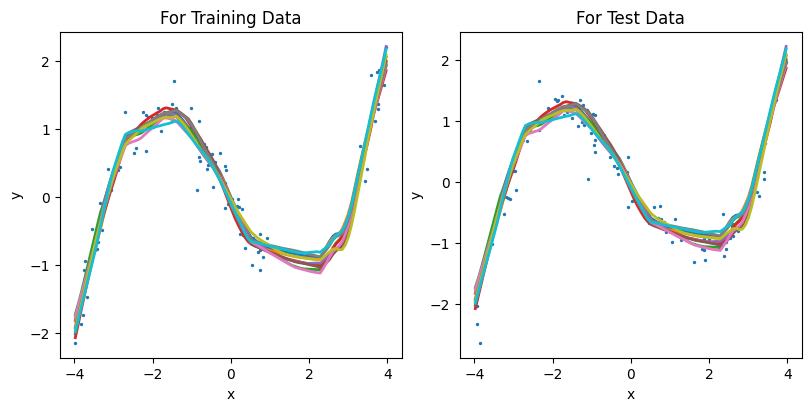

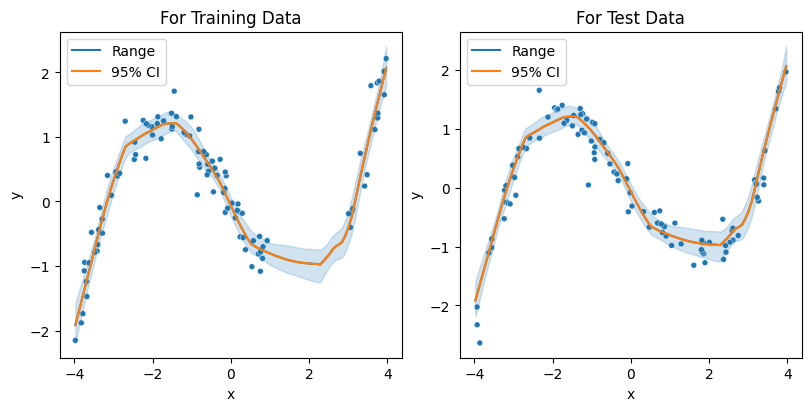

In [57]:
σ, τ = 1, 0.25
samples, is_accepted = run_hmc(layer, σ, τ, train_params_for_hmc_bnn, hmc_params, hmc_filter_params, random_samples_to_show, lr=lr, force_model_initialization=True)
np.save(f'storage/hmc_samples--problem_{cur_problem_id}', np.array(samples), allow_pickle=False)

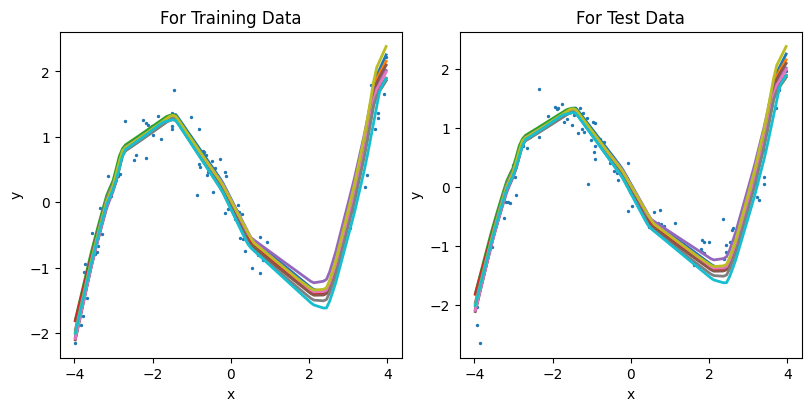

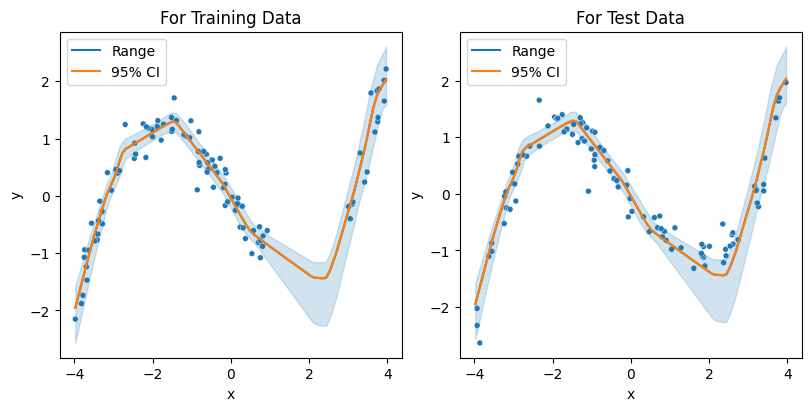

In [58]:
run_vi(prior_mu, prior_sigma, bayesian_layers, train_params_for_vi_bnn, random_samples_to_show, lr=lr, force_model_initialization=True)

## Problem C

In [15]:
assign_data('C')

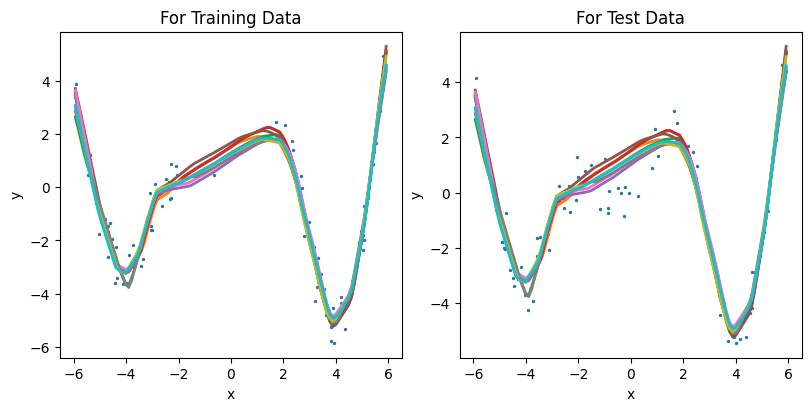

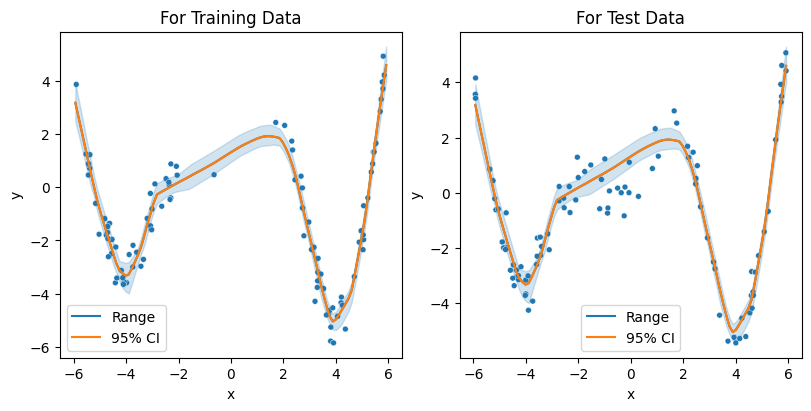

In [16]:
σ, τ = 1, 0.5
samples, is_accepted = run_hmc(layer, σ, τ, train_params_for_hmc_bnn, hmc_params, hmc_filter_params, random_samples_to_show, lr=lr, force_model_initialization=True)
np.save(f'storage/hmc_samples--problem_{cur_problem_id}', np.array(samples), allow_pickle=False)

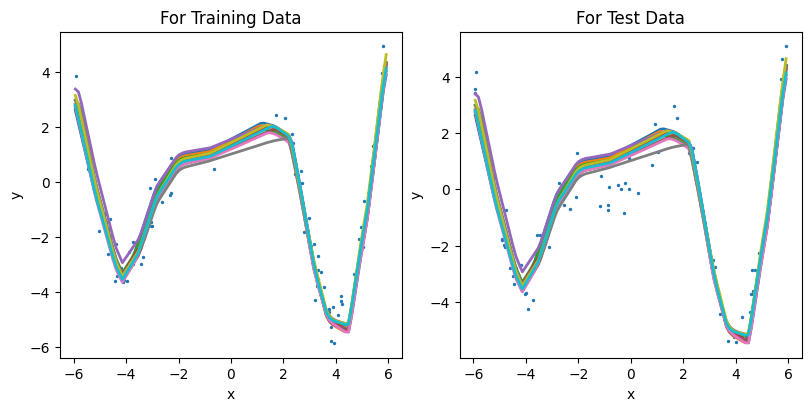

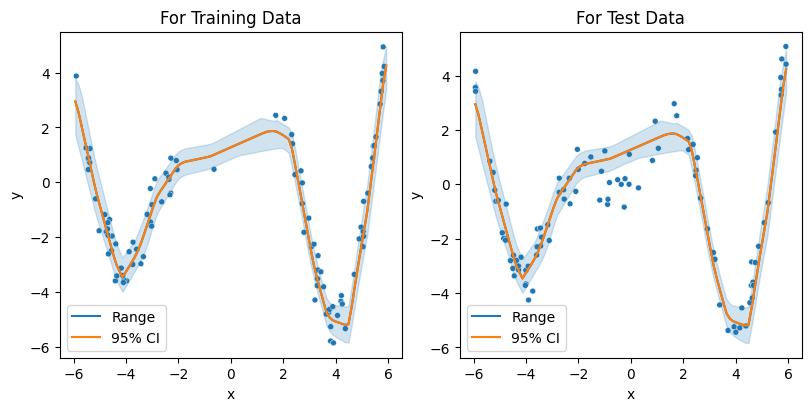

In [18]:
run_vi(prior_mu, prior_sigma, bayesian_layers, train_params_for_vi_bnn, random_samples_to_show, lr=lr, force_model_initialization=True)

## Problem D

In [20]:
assign_data('D')

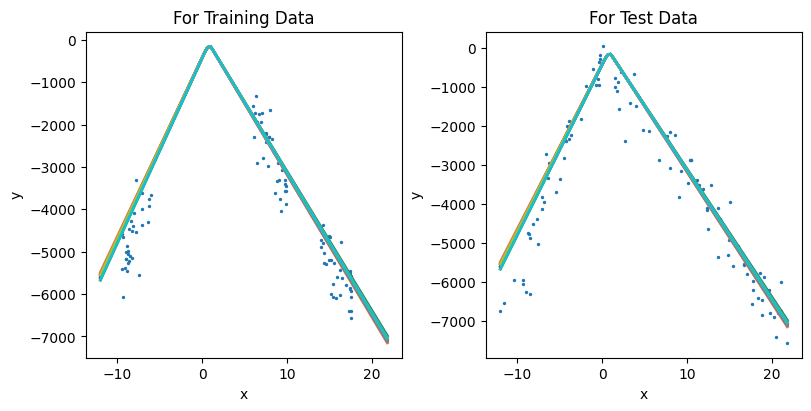

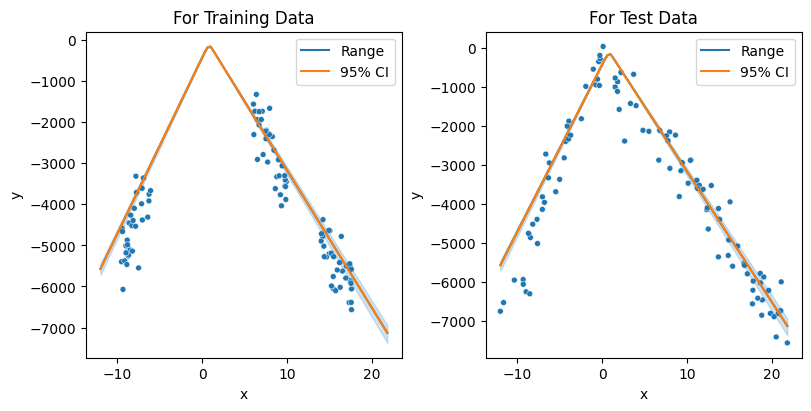

In [21]:
σ, τ = 1, 500
samples, is_accepted = run_hmc(layer, σ, τ, train_params_for_hmc_bnn, hmc_params, hmc_filter_params, random_samples_to_show, lr=lr, force_model_initialization=True)
np.save(f'storage/hmc_samples--problem_{cur_problem_id}', np.array(samples), allow_pickle=False)

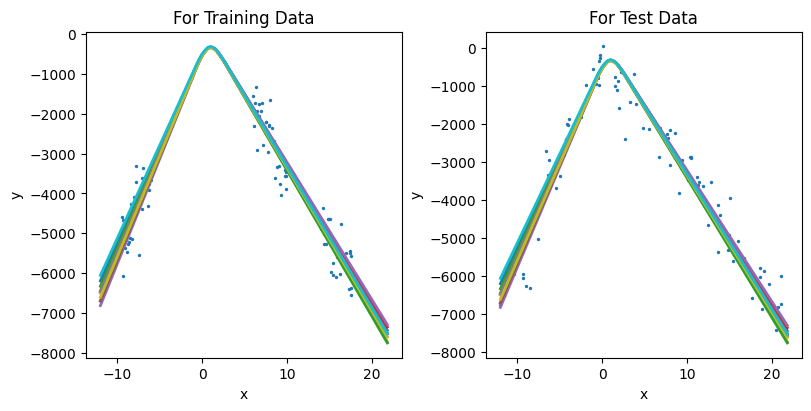

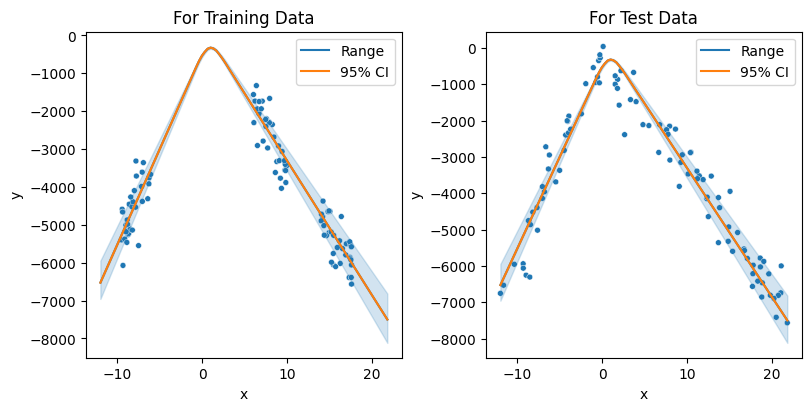

In [22]:
run_vi(prior_mu, prior_sigma, bayesian_layers, train_params_for_vi_bnn, random_samples_to_show, lr=lr, force_model_initialization=True)